In [46]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

## Global Variables

In [47]:
start_year = 2020
end_year = 2024

climate_dir = "climate_timeseries"
vegetation_dir = "cluster_timeseries/classification_result"

kecamatan_names = ['warungkondang', 'cibeber', 'campaka']

# available_climate_datasets = ['POWER_warungkondang.csv', 'POWER_cibeber.csv']
available_climate_datasets = ['era5_warungkondang.csv', 'era5_cibeber.csv']
available_vegetation_datasets = ['warungkondang.csv', 'cibeber3.csv']

era5_features = [
        # Temperature variables
        'temperature_2m',                       # Air temperature
        'temperature_2m_min',                   # Daily minimum air temperature
        'temperature_2m_max',                   # Daily maximum air temperature
        'soil_temperature_level_1',             # Topsoil temperature (0-7 cm)
        'soil_temperature_level_2',             # Soil temperature (7-28 cm)
        
        # Moisture variables
        'volumetric_soil_water_layer_1',        # Topsoil moisture content
        'volumetric_soil_water_layer_2',        # Soil moisture (7-28 cm)
        'volumetric_soil_water_layer_3',        # Soil moisture (28-100 cm)
        'total_precipitation_sum',              # Total rainfall and snow
        'dewpoint_temperature_2m',              # Air humidity indicator
        
        # Radiation and energy variables
        'surface_solar_radiation_downwards_sum', # Solar radiation at surface
        'surface_net_solar_radiation_sum',       # Net solar radiation at surface
        
        # Evaporation and water cycle
        'total_evaporation_sum',                 # Actual evaporation
        
        # Wind variables
        'u_component_of_wind_10m',               # East-west wind component
        'v_component_of_wind_10m'                # North-south wind component
    ]

extract_statistics = ['mean', 'min', 'max', 'std']

## Global Functions

In [48]:
def difference_df(df):
    df = df.diff()
    return df

## Climate Datasets

In [49]:
# df_OpenWeather = pd.read_csv(f"{data_dir}/OpenWeather_pandanwangi.csv")
climate_df = {}
try:
    for i, dataset in enumerate(available_climate_datasets):
        curr = pd.read_csv(f"{climate_dir}/{dataset}")
        climate_df[kecamatan_names[i]] = curr
except:
    print(f"file kecamatan {kecamatan_names[i]} belum ada")

In [50]:
preprocessed_climate = {}
def power_climate_preprocessing(df):
    df['datetime'] = pd.to_datetime(df['YEAR'].astype(str) + 
                                  df['DOY'].astype(str), 
                                  format='%Y%j')

    df.set_index('datetime', inplace=True) # set kolom DATE sebagai index terbaru
    df = df.drop(columns=['YEAR', 'DOY'], axis=0)
    df = df.replace(-999, np.nan)
    df = df.ffill()

    '''
    Columns description:
    T2M           MERRA-2 Temperature at 2 Meters (C)
    T2MDEW        MERRA-2 Dew/Frost Point at 2 Meters (C)
    T2MWET        MERRA-2 Wet Bulb Temperature at 2 Meters (C)
    TS            MERRA-2 Earth Skin Temperature (C)
    T2M_RANGE     MERRA-2 Temperature at 2 Meters Range (C)
    T2M_MAX       MERRA-2 Temperature at 2 Meters Maximum (C)
    T2M_MIN       MERRA-2 Temperature at 2 Meters Minimum (C)
    PS            MERRA-2 Surface Pressure (kPa)
    WS2M          MERRA-2 Wind Speed at 2 Meters (m/s)
    WS2M_MAX      MERRA-2 Wind Speed at 2 Meters Maximum (m/s)
    WS2M_MIN      MERRA-2 Wind Speed at 2 Meters Minimum (m/s)
    GWETTOP       MERRA-2 Surface Soil Wetness (1)
    GWETROOT      MERRA-2 Root Zone Soil Wetness (1)
    '''
    return df[(df.index.year >= start_year) & (df.index.year <= end_year)]

def era5_climate_preprocessing(df):
    df['datetime'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df.set_index('datetime', inplace=True) # set kolom DATE sebagai index terbaru

    df = df[era5_features]
    return df

for kec in kecamatan_names:
    preprocessed_climate[kec] = era5_climate_preprocessing(climate_df[kec])

In [51]:
print(preprocessed_climate["warungkondang"].head())

            temperature_2m  temperature_2m_min  temperature_2m_max  \
datetime                                                             
2020-01-01      294.405910          292.571769          296.173437   
2020-01-02      294.888343          292.931534          298.139136   
2020-01-03      295.601800          293.392362          299.309233   
2020-01-04      295.424454          293.395753          298.331850   
2020-01-05      295.238176          293.165118          297.992873   

            soil_temperature_level_1  soil_temperature_level_2  \
datetime                                                         
2020-01-01                295.892109                296.718736   
2020-01-02                296.274000                296.636957   
2020-01-03                297.006556                296.996610   
2020-01-04                296.761882                297.014764   
2020-01-05                296.626558                296.929862   

            volumetric_soil_water_layer_1  vol

## Vegetation Datasets

In [52]:
vegetation_df = {}

try:
    for i, dataset in enumerate(available_vegetation_datasets):
        curr = pd.read_csv(f"{vegetation_dir}/{dataset}")
        vegetation_df[kecamatan_names[i]] = curr
except:
    ""

In [53]:
preprocessed_vegetation = {}

def vegetation_preprocessing(df):
    df = df.iloc[:, 1:]
    df = df[df.label == 'pandanwangi']
    df = df.set_index('cluster_id')
    df = df.describe()
    df = df.T
    df = df[extract_statistics]
    indexes = df.index
    new_indexes = []
    for i in indexes:
        date = pd.to_datetime(i, format='%Y%m%d')
        new_indexes.append(date)
    df['datetime'] = new_indexes
    df = df.set_index('datetime')
    return df[(df.index.year >= start_year) & (df.index.year <= end_year)]

for kec in kecamatan_names:
    preprocessed_vegetation[kec] = vegetation_preprocessing(vegetation_df[kec])

In [54]:
print(preprocessed_vegetation["warungkondang"])

                mean       min       max       std
datetime                                          
2020-01-10  0.552099  0.191099  0.842619  0.133512
2020-01-15  0.464686  0.191099  0.749521  0.127094
2020-01-17  0.464686  0.191099  0.749521  0.127094
2020-01-20  0.460831  0.191099  0.749521  0.125556
2020-01-25  0.391752  0.191099  0.611065  0.098316
...              ...       ...       ...       ...
2024-12-13  0.356538  0.159642  0.723054  0.130079
2024-12-14  0.356538  0.159642  0.723054  0.130079
2024-12-19  0.356538  0.159642  0.723054  0.130079
2024-12-24  0.332130  0.177510  0.707847  0.102945
2024-12-29  0.330613  0.177510  0.707847  0.103142

[409 rows x 4 columns]


In [55]:
differenced_climate = {}
differenced_vegetation = {}

intersecting_indices = preprocessed_climate['warungkondang'].index.intersection(preprocessed_vegetation['warungkondang'].index)

for kec in kecamatan_names:
    differenced_climate[kec] = difference_df(preprocessed_climate[kec].loc[intersecting_indices]).iloc[1:, :]
    differenced_vegetation[kec] = difference_df(preprocessed_vegetation[kec]).loc[intersecting_indices].iloc[1:, :]

In [56]:
# differenced_climate['warungkondang'].head()

In [57]:
differenced_vegetation['warungkondang'].head()

,mean,min,max,std
datetime,,,,
2020-01-15,-0.087413,0.000000,-0.093098,-0.006419
2020-01-17,0.000000,0.000000,0.000000,0.000000
2020-01-20,-0.003855,0.000000,0.000000,-0.001538
2020-01-25,-0.069079,0.000000,-0.138455,-0.027239
2020-02-24,0.057165,0.005744,0.033113,0.005823


In [58]:
# json extract
correlation_indexes = {}

for kec in kecamatan_names:
    kec_vegetation = differenced_vegetation[kec]
    kec_climate = differenced_climate[kec]
    stat_dict = {}
    for statistic in extract_statistics:
        curr_stat = kec_vegetation[statistic]
        cuaca_dict = {}
        for faktor_cuaca in era5_features:
            pearson = curr_stat.corr(kec_climate[faktor_cuaca], method='pearson')
            spearman = curr_stat.corr(kec_climate[faktor_cuaca], method='spearman')
            corr_dict = {
                'pearson': float(pearson),
                'spearman': float(pearson)
            }
            cuaca_dict[faktor_cuaca] = corr_dict
        stat_dict[statistic] = cuaca_dict
    correlation_indexes[kec] = stat_dict
            
# print(differenced_vegetation['warungkondang']['mean'].corr(differenced_climate['warungkondang']['temperature_2m'], method='pearson'))
# print(differenced_vegetation['warungkondang']['mean'].corr(differenced_climate['warungkondang']['soil_temperature_level_1'], method='pearson'))

In [59]:
# dataframe extract
correlation_indexes = {
    'kec': [],
    'statistic': [],
    'cuaca': [],
    'pearson': [],
    'spearman': []
}

for kec in kecamatan_names:
    kec_vegetation = differenced_vegetation[kec]
    kec_climate = differenced_climate[kec]
    stat_dict = {}
    for statistic in extract_statistics:
        curr_stat = kec_vegetation[statistic]
        cuaca_dict = {}
        for faktor_cuaca in era5_features:
            pearson = curr_stat.corr(kec_climate[faktor_cuaca], method='pearson')
            spearman = curr_stat.corr(kec_climate[faktor_cuaca], method='spearman')
            correlation_indexes['pearson'].append(pearson)
            correlation_indexes['spearman'].append(spearman)
            correlation_indexes['cuaca'].append(faktor_cuaca)
            correlation_indexes['statistic'].append(statistic)
            correlation_indexes['kec'].append(kec)

In [60]:
# print(json.dumps(correlation_indexes, indent=2))
correlation_df = pd.DataFrame(correlation_indexes)

In [70]:
selected_kec = 'warungkondang'
kec_corr = correlation_df[correlation_df['kec'] == selected_kec]
kec_corr.sort_values("pearson", ascending=False).head(15)

,kec,statistic,cuaca,pearson,spearman
59,warungkondang,std,v_component_of_wind_10m,0.154324,0.028566
52,warungkondang,std,volumetric_soil_water_layer_3,0.141664,0.106232
58,warungkondang,std,u_component_of_wind_10m,0.117424,0.016571
27,warungkondang,min,total_evaporation_sum,0.066825,0.056023
16,warungkondang,min,temperature_2m_min,0.066581,0.019840
47,warungkondang,std,temperature_2m_max,0.063850,0.038543
32,warungkondang,max,temperature_2m_max,0.057904,0.022096
56,warungkondang,std,surface_net_solar_radiation_sum,0.049874,0.044276
55,warungkondang,std,surface_solar_radiation_downwards_sum,0.049714,0.043414
24,warungkondang,min,dewpoint_temperature_2m,0.047513,-0.019198


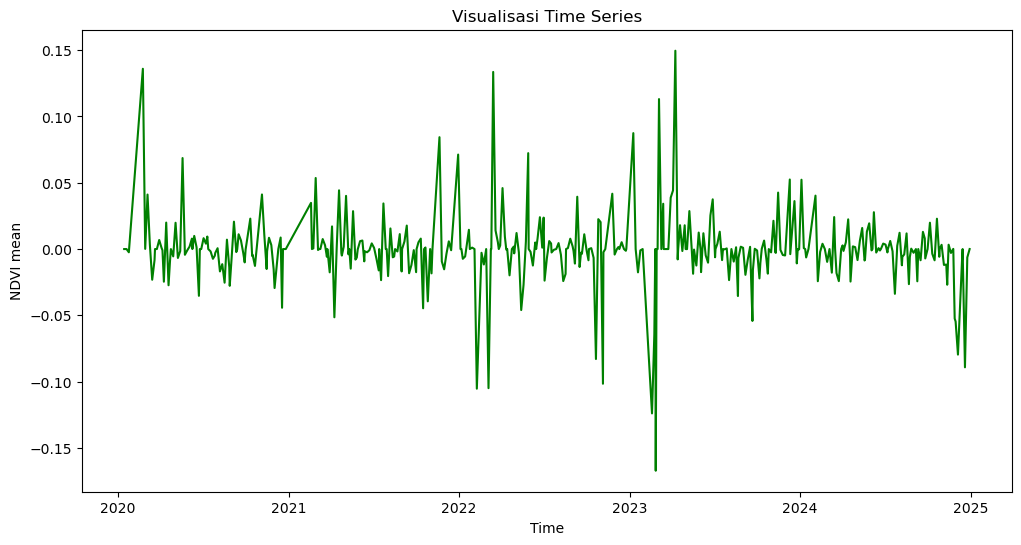

In [65]:
ts_df = differenced_vegetation['cibeber']

# for stat in statistic:
plt.figure(figsize=(12, 6))
plt.plot(ts_df.index, ts_df['mean'], label='NDVI mean', color='green')
plt.title(f'Visualisasi Time Series')
plt.xlabel('Time')
plt.ylabel('NDVI mean')
plt.show()

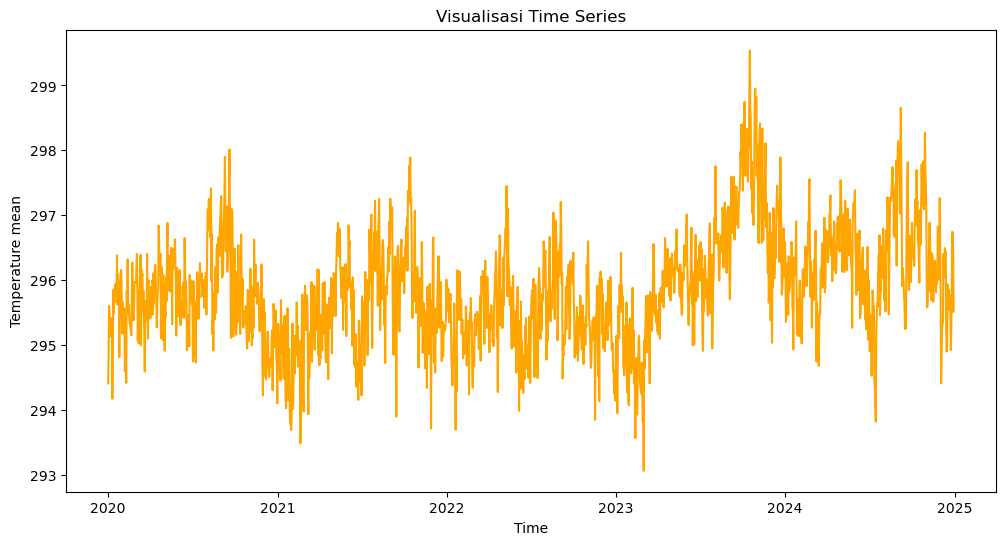

In [67]:
ts_df = preprocessed_climate['warungkondang']

plt.figure(figsize=(12, 6))
plt.plot(ts_df.index, ts_df['temperature_2m'], label='temperature_2m', color='orange')
plt.title(f'Visualisasi Time Series')
plt.xlabel('Time')
plt.ylabel('Temperature mean')
plt.show()